In [54]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

from epa import *
from sample_processing import *
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
%autoreload 2

# Generating Data

### Gaussians no each cluster has unique parameters

In [56]:
np.random.seed(640)

In [57]:
# Distribution on X
mus = [-2, 0 ,2]
sds = [1, 1, 1]
n_points_per_clust = 100

inds = np.array(n_points_per_clust*[0] + n_points_per_clust*[1] + n_points_per_clust*[2])

beta = np.array([[0.5, 2.5, 0.5, 0.4],
                 [-4.5, -3, 0.3, 0],
                 [2, -1.5, 1, -2.0]])

Xs = []
Y_trt = []
Y_control = []
Ds = []

for k in range(len(mus)):
    
    D_k = np.random.binomial(1, 0.5, n_points_per_clust)
    X_k = np.random.normal(mus[k],sds[k],n_points_per_clust)
    
    y_trt_k = beta[k][0] + beta[k][1]*1 + beta[k][2]*X_k + beta[k][3]*(X_k*1) + np.random.normal(0,1, n_points_per_clust)
    y_ctrl_k = beta[k][0] + beta[k][1]*0 + beta[k][2]*X_k + beta[k][3]*(X_k*0) + np.random.normal(0,1, n_points_per_clust)
    
    Xs.append(X_k)
    Y_trt.append(y_trt_k)
    Y_control.append(y_ctrl_k)
    Ds.append(D_k)

Y_trt = np.concatenate(Y_trt)
Y_control = np.concatenate(Y_control)
Xs = np.concatenate(Xs)
Ds = np.concatenate(Ds)
trt_effect = Y_trt - Y_control
Y_obs = np.array([Y_trt[i] if Ds[i]==1 else Y_control[i] for i in range(len(Ds))])

dataset2 = {'Yobs': Y_obs,
            'Xobs': Xs,
            'Dobs': Ds,
             'Y_1':Y_trt,
            'Y_0':Y_control,
             'Y_1-Y_0':trt_effect,
            'cluster_id':inds}

In [58]:
col_map = ['r','b','g']

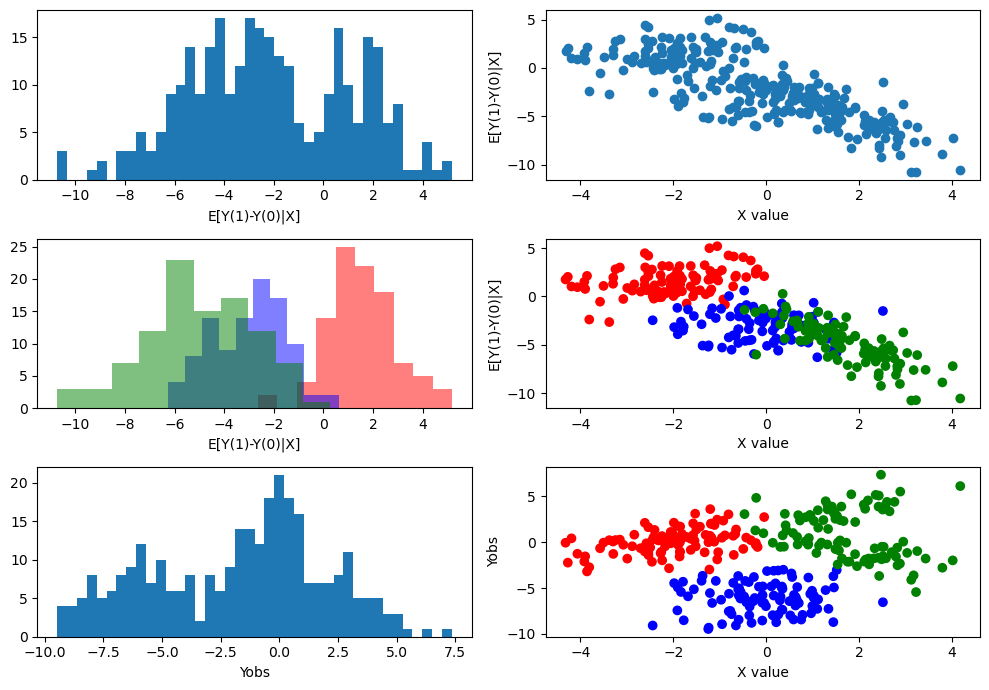

In [59]:
fig, ax = plt.subplots(3,2,figsize=(10,7))

ax[0,0].hist(trt_effect,bins=40)
ax[0,0].set_xlabel('E[Y(1)-Y(0)|X]')

ax[0,1].scatter(Xs,trt_effect)
ax[0,1].set_xlabel('X value')
ax[0,1].set_ylabel('E[Y(1)-Y(0)|X]')

for i in range(len(mus)):
    ax[1,0].hist(trt_effect[np.where(inds==i)],
                 color=col_map[i],alpha=0.5)
ax[1,0].set_xlabel('E[Y(1)-Y(0)|X]')
    
ax[1,1].scatter(Xs,trt_effect,c=[col_map[i] for i in inds])
ax[1,1].set_xlabel('X value')
ax[1,1].set_ylabel('E[Y(1)-Y(0)|X]')

ax[2,0].hist(Y_obs,bins=40)
ax[2,0].set_xlabel('Yobs')

ax[2,1].scatter(Xs,Y_obs, c=[col_map[i] for i in inds])
ax[2,1].set_xlabel('X value')
ax[2,1].set_ylabel('Yobs')




plt.tight_layout()
plt.show()

In [ ]:
plt.savefig('Plots/simulated_cluster_scatter.png')


# Run Gibbs Sampler

In [60]:
# Regression covariates
Xs = np.vstack([np.ones(len(dataset2['Dobs'])),
           dataset2['Dobs'],
           dataset2['Xobs'],
           dataset2['Dobs']*dataset2['Xobs']]).T

# Regression outcomes
Ys = dataset2['Yobs']
# matrix to calculate similarities
Zs = dataset2['Xobs']

In [61]:
# Form distance matrix with similar covariates
tau = 0.2
lambda_matrix = pairwise_distances(X=Zs.reshape(-1,1), metric=exp_sim_func, tau=tau)

n = len(Ys)
# intialize 
partition_samp = np.array(n//3*[1]+n//3*[2]+n//3*[3])
names_used = [1,2,3]
alpha_samp = 0.5

delta_samp = 0
sim_mat = lambda_matrix
order_samp = np.arange(n)
np.random.shuffle(order_samp)
phi_samp = np.array([[0.5,0.5,0.5,0.5],
                     [2,2,0.5,0.5],
                     [-1,-1,0.5,0.5]])

#### gibbs sampling hyper parameters
n_gibbs = 10000
k = 100 # no. of numbers to permute order

# GRW sampler param
rw_sd = 0.2

# alpha prior
a_alpha = 1
b_alpha = 10
alpha_bounds = [0,1e99]

# delta prior
a_delta = 1
b_delta = 1
w = 0.5
delta_bounds = [0,1]


# phi / regression prior
phi_mean_prior = np.array([0,0,0,0])
phi_cov_prior = np.eye(4)

sigma_reg = 1

partition_save = []
alpha_save = []
delta_save = []
phi_save = []
log_prob_save = []

# Gibbs loop
for g in range(n_gibbs):
    if g%1000 == 0:
        print("Gibbs: ", g)
        
    # Sample cluster for each i 
    for i in range(len(Ys)):

        partition_samp,phi_samp, names_used = sample_conditional_i_clust_alt(i,
                                         partition_samp,
                                         alpha_samp,
                                         delta_samp,
                                         sim_mat,
                                         order_samp,
                                         phi_samp, Ys, Xs, sigma_reg,
                                        names_used,
                                         phi_base_mean=phi_mean_prior,
                                            phi_base_cov=phi_cov_prior)
        
    
    # Update phis
    phi_samp = sample_phi(phi_samp, Ys, Xs, partition_samp,
               phi_mean_prior,
               phi_cov_prior,
               sigma_reg)
    
    # Sample ordering 
    #order_samp = permute_k(order_samp, k)
    order_samp = metropolis_step_order(order_current=order_samp,
                                       alpha=alpha_samp,
                                       delta=delta_samp,
                                       partition=partition_samp,
                                       sim_mat=sim_mat,
                                       k=k)
    
        
    #### Sample parameters, alpha, sigma
    
    alpha_samp = metropolis_step_alpha(alpha_samp, rw_sd, a_alpha, b_alpha,
                         partition_samp,
                             delta_samp,
                             sim_mat,
                             order_samp,bounds=alpha_bounds)
    
    
    delta_samp = metropolis_step_delta(delta_samp, rw_sd, a_delta, b_delta, w,
                         partition_samp,
                             alpha_samp,
                             sim_mat,
                             order_samp,bounds=delta_bounds)
    
    #alpha_samp = 0.5
    #delta_samp = 0
    
    
    # Calc log prob of result
    log_prob_samp = calc_log_joint(partition=partition_samp,
                                   phi=phi_samp,
                                   y=Ys,
                                   x=Xs,
                                   sim_mat=sim_mat,
                                   order=order_samp,
                                   alpha=alpha_samp,
                                   delta=delta_samp,
                                   sigma_reg = sigma_reg)
    
    # Save sampled values
    log_prob_save.append(log_prob_samp)
    partition_save.append(partition_samp)
    alpha_save.append(alpha_samp)
    delta_save.append(delta_samp)
    phi_save.append(phi_samp)

Gibbs:  0
Gibbs:  1000
Gibbs:  2000
Gibbs:  3000
Gibbs:  4000
Gibbs:  5000
Gibbs:  6000
Gibbs:  7000
Gibbs:  8000
Gibbs:  9000


# Calculating Similarity Matrix from MCMC samples

In [62]:
normalized_sim_mat = calc_hit_matrix(partition_save,
                                     burn_samples=5000,
                                     normalize=True)

In [142]:
plt.rcParams.update({'font.size': 8})

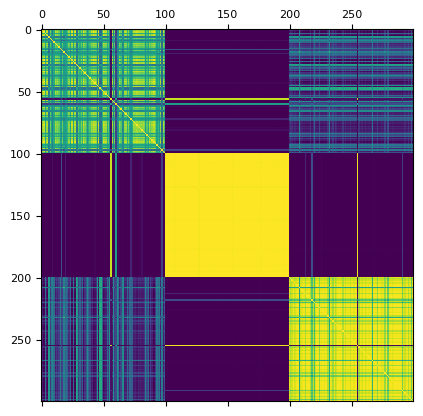

In [143]:
plt.matshow(normalized_sim_mat)
plt.savefig('Plots/Simulated Posterior Similarity Matrix.png')
plt.show()

In [64]:
agglo_cluster_solution = agglo_cluster(sim_matrix=normalized_sim_mat,
                                       n_clust=3,
                                       linkage_type='complete')

In [65]:
pd.Series(agglo_cluster_solution).value_counts()

1    106
2    103
0     91
dtype: int64

In [66]:
col_map=['r', 'b', 'g','k','m','y','tab:orange']

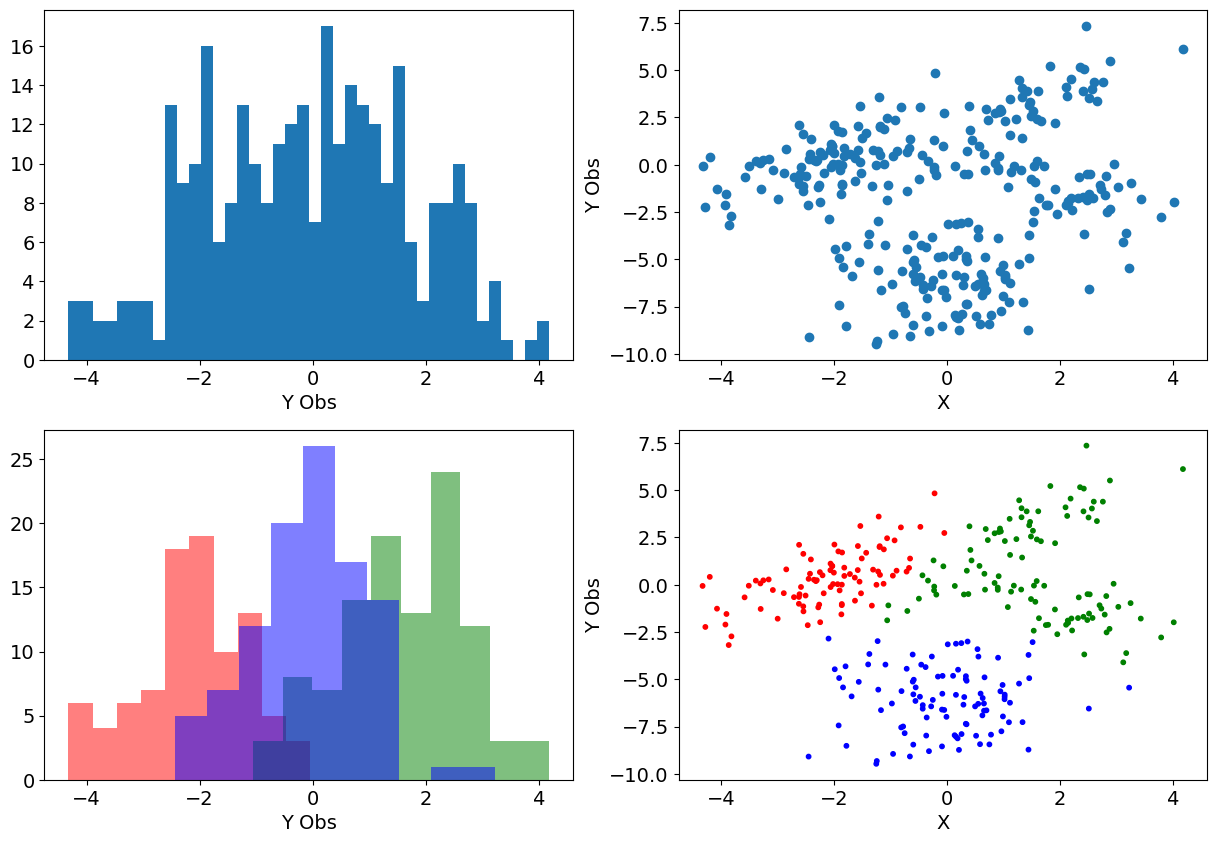

In [109]:
fig, ax = plt.subplots(2,2,figsize=(15,10))

ax[0,0].hist(Xs[:,2],bins=40)
ax[0,1].scatter(Xs[:,2],Ys)
inds = [0,1,2]
for i in inds:
    ax[1,0].hist(Xs[:,2][np.where(agglo_cluster_solution==i)],
                 color=col_map[i],alpha=0.5)

ax[1,1].scatter(Xs[:,2],Ys,c=[col_map[i] for i in agglo_cluster_solution],s=10)

ax[0,0].set_xlabel('Y Obs')
ax[1,0].set_xlabel('Y Obs')

ax[0,1].set_xlabel('X')
ax[0,1].set_ylabel('Y Obs')

ax[1,1].set_xlabel('X')
ax[1,1].set_ylabel('Y Obs')

plt.savefig('Plots/simulated_cluster_scatter.png')

plt.show()

# MCMC Diagnostics

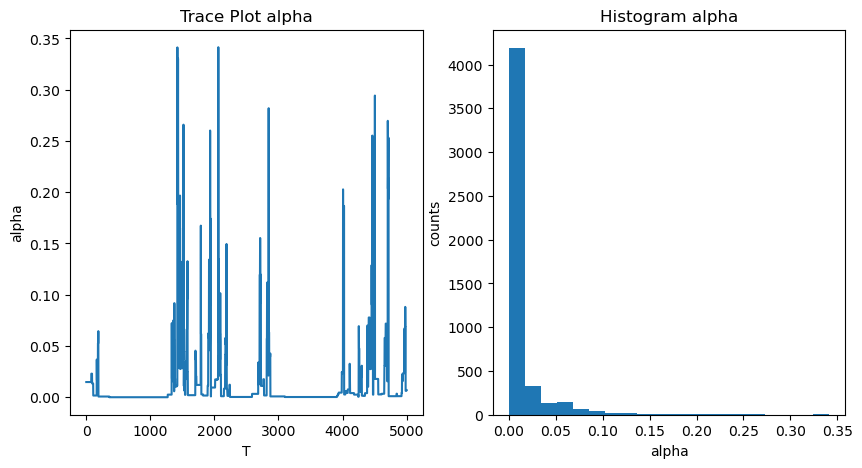

In [68]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(alpha_save[5000:])
ax[0].set_xlabel('T')
ax[0].set_ylabel('alpha')
ax[0].set_title('Trace Plot alpha')

ax[1].hist(alpha_save[5000:],bins=20)
ax[1].set_xlabel('alpha')
ax[1].set_ylabel('counts')
ax[1].set_title('Histogram alpha')
plt.show()

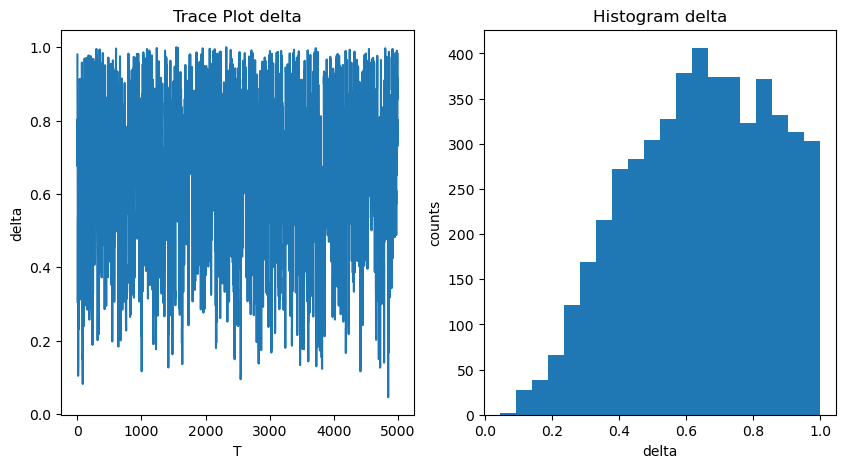

In [69]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(delta_save[5000:])
ax[0].set_xlabel('T')
ax[0].set_ylabel('delta')
ax[0].set_title('Trace Plot delta')

ax[1].hist(delta_save[5000:],bins=20)
ax[1].set_xlabel('delta')
ax[1].set_ylabel('counts')
ax[1].set_title('Histogram delta')
plt.show()

# Get predictive distribution

### Loop over conditionally correct params to get clusters

In [70]:
n_burn_in = 5000

In [71]:
n_data = len(Ys)
y_0 = []
y_1 = [] 
y_pred = []

for g in range(n_burn_in,len(partition_save)):
#for g in sim_clusters_samples:
    
    if g < n_burn_in:
        continue
    
    partition_g = partition_save[g]
    phi_g = phi_save[g]
    
    y_1_g = np.zeros(n_data)
    y_0_g = np.zeros(n_data)
    y_pred_g = np.zeros(n_data)
    for i in range(n_data):
        
        # get stuff        
        actual_x_val = Xs[i][2]
        actual_input = Xs[i]
        y0_inputs = np.concatenate([np.array([1,0]), np.array([actual_x_val]), np.array([actual_x_val*0])])
        y1_inputs = np.concatenate([np.array([1,1]), np.array([actual_x_val]), np.array([actual_x_val*1])]) 
        
        part_i = partition_g[i]
        phi_i = phi_g[part_i-1]
        
        y0_pred = phi_i @ y0_inputs
        y1_pred = phi_i @ y1_inputs
        yobs_pred = phi_i @ actual_input
        
        y_0_g[i] = y0_pred
        y_1_g[i] = y1_pred
        y_pred_g[i] = yobs_pred
    
    y_1.append(y_1_g)
    y_0.append(y_0_g)
    y_pred.append(y_pred_g)

y_1 = np.array(y_1)
y_0 = np.array(y_0)
y_pred = np.array(y_pred)

In [72]:
hte_samples = y_1 - y_0  
y_1_mean = y_1.mean(0)
y_0_mean = y_0.mean(0)
hte_sample_mean = hte_samples.mean(0)

## Check model fit

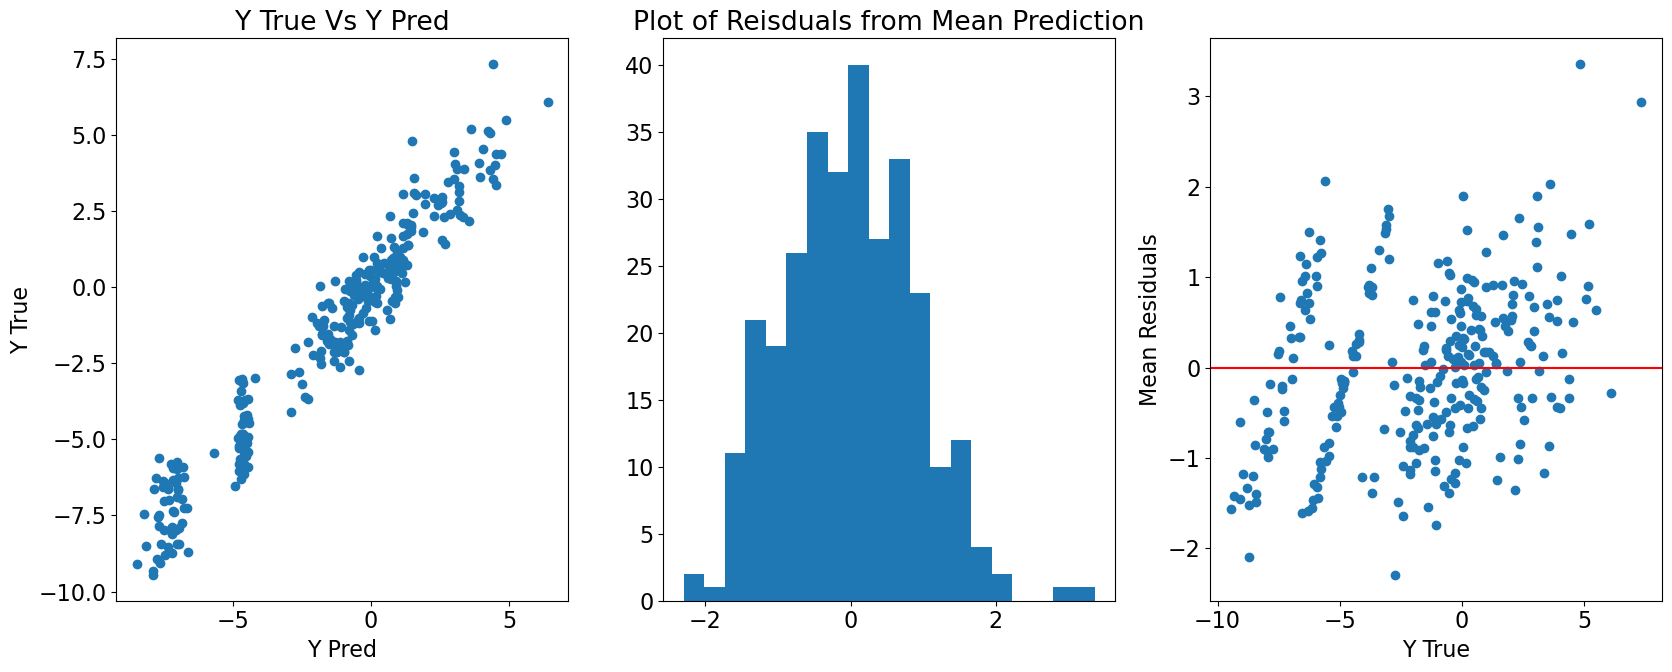

In [152]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1,3, figsize=(17,7))
ax[0].scatter(y_pred.mean(0),Ys)
ax[0].set_xlabel('Y Pred')
ax[0].set_ylabel('Y True')
ax[0].set_title('Y True Vs Y Pred')

residuals_mean = Ys - y_pred.mean(0)
ax[1].hist(residuals_mean,bins=20)
ax[1].set_title("Plot of Reisduals from Mean Prediction")

ax[2].scatter(Ys, residuals_mean)
ax[2].set_xlabel('Y True')
ax[2].set_ylabel('Mean Residuals')
ax[2].axhline(0, color='red')

plt.tight_layout()
plt.savefig('Plots/simuated_diagnostics.png')

plt.show()

## Plot HTE of Samples

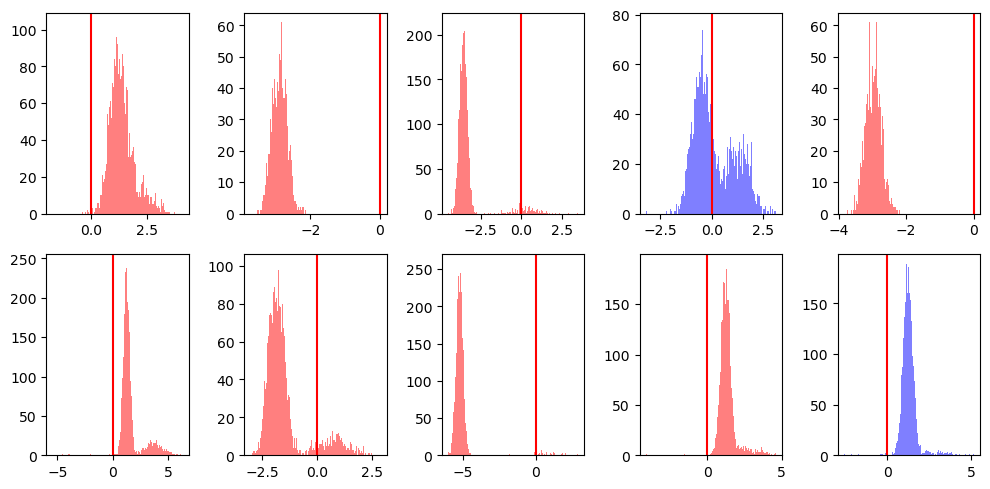

In [74]:
fig,ax = plt.subplots(2,5,figsize=(10,5))

plot_vals = np.random.choice(list(range(300)),10)

i = 0
for j in range(5):
    for k in range(2):
        
        point_clus = agglo_cluster_solution[i]
        
        ax[k,j].hist(hte_samples[:,plot_vals[i]],bins=300,
                     color=col_map[agglo_cluster_solution[i]],alpha=0.5)
        
        ax[k,j].axvline(0,color='red')
        i+=1
plt.tight_layout()
plt.show()

Calculate some Stats

In [75]:
col_map = ['red','green','blue']

In [91]:
plt.rcParams.update({'font.size': 14})

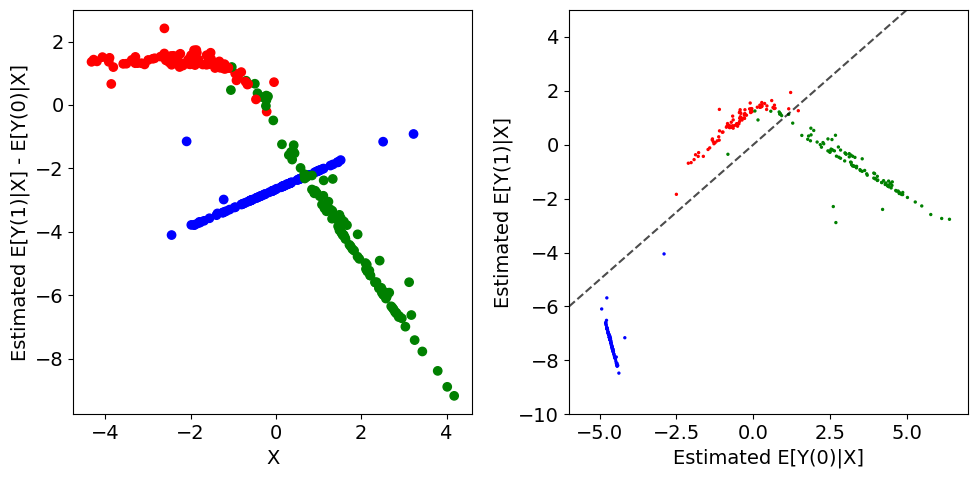

In [150]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].scatter(dataset2['Xobs'], hte_sample_mean, color=[col_map[c] for c in agglo_cluster_solution])
ax[0].set_xlabel('X')
ax[0].set_ylabel('Estimated E[Y(1)|X] - E[Y(0)|X]')

ax[1].axline([0, 0], [1, 1], color='black', alpha=0.7, linestyle='--')

ax[1].scatter(y_0_mean, y_1_mean, color=[col_map[c] for c in agglo_cluster_solution], s=2)

ax[1].set_xlabel('Estimated E[Y(0)|X]')
ax[1].set_ylabel('Estimated E[Y(1)|X]')

ax[1].set_xlim(ax_min, ax_max)
ax[1].set_ylim(ax_min, ax_max)

ax[1].set_xlim(-6, 7)
ax[1].set_ylim(-10, 5)
plt.tight_layout()

plt.savefig('Plots/Simulated_output_scatted.png')
plt.show()

In [136]:
col_map = ['red','green','blue']

In [137]:
import seaborn as sns

In [145]:
plt.rcParams.update({'font.size': 14})

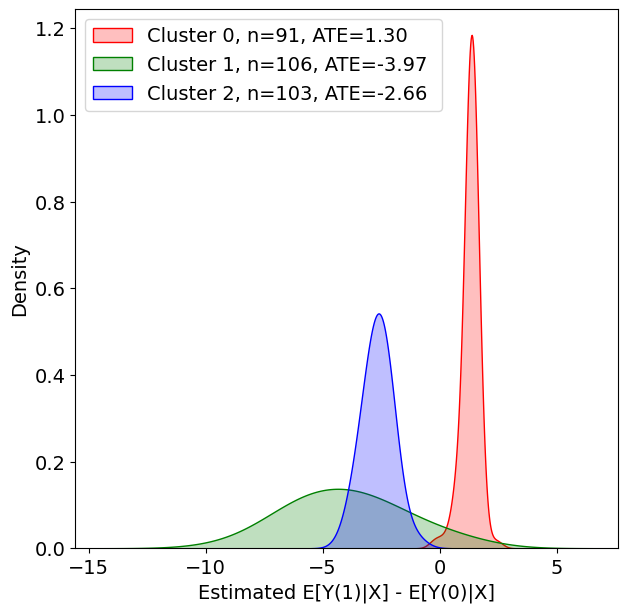

In [147]:
hte_sample_mean = hte_samples.mean(0)

fig, ax = plt.subplots(figsize=(7,7))

for i,c in enumerate(np.unique(agglo_cluster_solution)):
    
    sample_htes = hte_sample_mean[np.where(agglo_cluster_solution==c)[0]]
    n_c = len(sample_htes)
    if n_c < 10:
        continue
    #ax.hist(sample_htes,bins=5, color=col_map[i], alpha=0.5)
    lab = f'Cluster {c}, n={n_c}, ATE={np.mean(sample_htes):.2f} '
    sns.kdeplot(data=sample_htes,color=col_map[i],label=lab, ax=ax,fill=True,bw_adjust=2)
    #ax.axvline(np.mean(sample_htes),color=col_map[i])

ax.set_xlabel('Estimated E[Y(1)|X] - E[Y(0)|X]')
ax.legend(loc='upper left')
plt.savefig('Plots/Simulated_output_histogram.png')
plt.show()

In [80]:
y_1_mean = y_1[0:,:].mean(0)
y_0_mean = y_0[0:,:].mean(0)

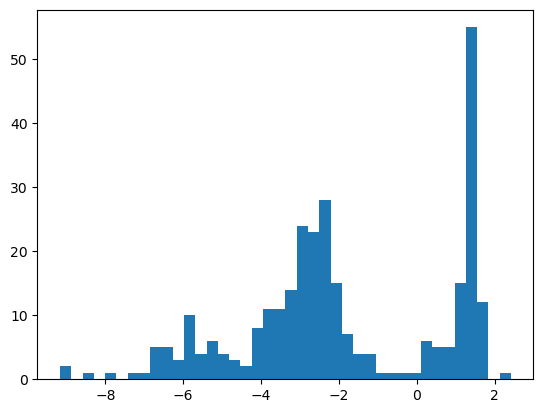

In [81]:
# HTE Mean Estimates
plt.hist(y_1_mean - y_0_mean, bins=40)
plt.show()